# YearPredictionMSD dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/yearprediction(463715, 90).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'year prediction'
file_name = data_name

x_tr = x_tr.toarray()[:1e5 * 1.25, :].T
y_tr = y_tr[:1e5 * 1.25]
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 100000
of features 90
year prediction


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Linear SVM
We train an SVM with linear kernel for reference.

In [6]:
svm = LinearSVR(C=1e0)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.18896676527735246

In [7]:
np.sqrt(mean_squared_error(y_test, pred))

0.8886236132722114

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [8]:
ind_num = 500
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [3]:
cov_params = np.array([.5, 30., 1.])
# cov_params = np.array([1., 1., .5])

In [10]:
# np.save('yearpred_inputs.npy', inputs)

In [4]:
inputs = np.load('yearpred_inputs.npy')
ind_num = inputs.shape[1]

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [18]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [19]:
opts = {'maxiter': 30, 'mydisp': True, 'print_freq': 1}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  0.5         30.           1.          -2.31047503   0.99771221]
Hyper-parameters at iteration 1 : [  0.52415235  29.99967524   0.93690655  -2.31047503   0.99771221]
Hyper-parameters at iteration 2 : [  0.53055948  29.99968428   0.93289456  -2.31048551   0.99769933]
Hyper-parameters at iteration 3 : [  0.53294557  29.99976171   0.93454242  -2.31049705   0.99768486]
Hyper-parameters at iteration 4 : [  0.53520207  30.00002221   0.93604277  -2.31052708   0.99764689]
Hyper-parameters at iteration 5 : [  0.53628719  30.00119523   0.93672236  -2.31064807   0.99749306]
Hyper-parameters at iteration 6 : [  0.53788988  30.00522999   0.93762066  -2.31106007   0.99696843]
Hyper-parameters at iteration 7 : [  0.5425975   30.02477937   0.93990681  -2.31304735   0.99443476]
Hyper-parameters at iteration 8 : [  0.54927187  30.06808778   0.94242499  -2.31743046   0.98883683]
Hyper-parameters at iteration 9 : [  0.55932844  30.16622736   0.94469025  -2.3273042    0.

In [20]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_x_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'i', freq=1)

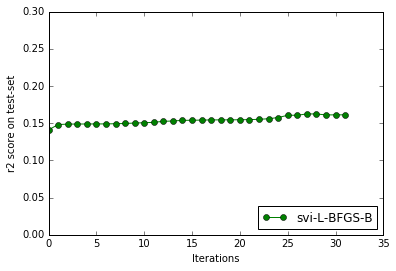

In [21]:
plt.plot(lbfgs_svi_x_lst, lbfgs_svi_y_lst, '-go', label='svi-L-BFGS-B')
plt.ylim([0., .3])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [22]:
lbfgs_svi_res.times[-1]

3884.8399562835693

In [13]:
lbfgs_svi_y_lst[-1]

0.15059519563970181

In [202]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_x.npy', lbfgs_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [61]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [62]:
opts = {'maxiter': 20, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  0.5  30.    1. ]
Hyper-parameters at iteration 1 : [  1.35364792  29.97438629   0.99915447]
Hyper-parameters at iteration 2 : [  1.38073914  29.97420672   0.91299068]
Hyper-parameters at iteration 3 : [  1.15080952  29.98178927   0.89400849]
Hyper-parameters at iteration 4 : [  1.08679049  29.98495386   0.89983383]
Hyper-parameters at iteration 5 : [  1.09437491  29.98566105   0.89885422]
Hyper-parameters at iteration 6 : [  1.09536317  29.98653366   0.89876494]
Hyper-parameters at iteration 7 : [  1.1006176   29.9964438    0.89827263]
Hyper-parameters at iteration 8 : [  1.10797536  30.02162249   0.8976427 ]
Hyper-parameters at iteration 9 : [  1.12218366  30.09963257   0.89653171]
Hyper-parameters at iteration 10 : [  1.14818466  30.31074871   0.89478201]
Hyper-parameters at iteration 11 : [  1.20100744  30.89517041   0.89191581]
Hyper-parameters at iteration 12 : [  1.31658955  32.49990295   0.88735164]
Hyper-parameters at iteration 13 : [  1.601

In [63]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 'i', freq=1, verbose=True, print_freq=1.)

Processing parameter number1/22
Processing parameter number2/22
Processing parameter number3/22
Processing parameter number4/22
Processing parameter number5/22
Processing parameter number6/22
Processing parameter number7/22
Processing parameter number8/22
Processing parameter number9/22
Processing parameter number10/22
Processing parameter number11/22
Processing parameter number12/22
Processing parameter number13/22
Processing parameter number14/22
Processing parameter number15/22
Processing parameter number16/22
Processing parameter number17/22
Processing parameter number18/22
Processing parameter number19/22
Processing parameter number20/22
Processing parameter number21/22
Processing parameter number22/22


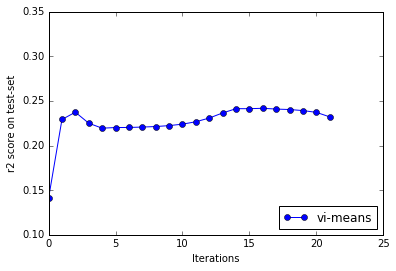

In [64]:
plt.plot(vi_x_lst, vi_y_lst, '-bo', label='vi-means')
plt.ylim([.1, .35])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [65]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_x.npy', vi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [42]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [43]:
opts = {'mydisp': True, 'print_freq': 1, 'step_rate': 1.,
                'maxiter': 5, 'batch_size':5000}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Using AdaDelta optimizer
Iteration  1 :
	Gradient norm 0.0276714572428
Iteration  2 :
	Gradient norm 0.0798575522584
Iteration  3 :
	Gradient norm 0.183044359153
Iteration  4 :
	Gradient norm 0.328347668621
Iteration  5 :
	Gradient norm 0.0712899962257


In [44]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_x_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'i', freq=1, verbose=True, print_freq=1.)

Processing parameter number1/6
Processing parameter number2/6
Processing parameter number3/6
Processing parameter number4/6
Processing parameter number5/6
Processing parameter number6/6


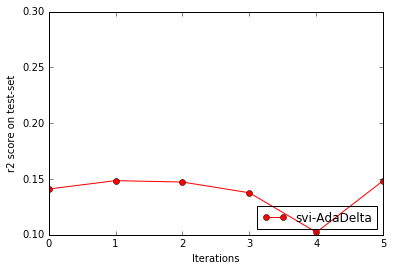

In [45]:
plt.plot(ad_svi_x_lst, ad_svi_y_lst, '-ro', label='svi-AdaDelta')
plt.ylim([.1, .3])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [227]:
ad_svi_y_lst[-1]

0.70205701424333622

In [228]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_x.npy', ad_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)